# Training neural network: Data augmentation

Tiếp nối bài thực hành trên lớp, bài tập về nhà này vẫn sử dụng MNIST là tập dữ liệu thử nghiệm. Mục tiêu là cải thiện hiệu suất của mô hình bằng các kỹ thuật Augmentation nhằm tăng cường số lượng dữ liệu

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from keras.datasets import mnist
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

%load_ext tensorboard
!rm -rf './graph/dropout/dropout=0.5,relu/'

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print('Training image: ', x_train.shape)
print('Testing image: ', x_test.shape)
print('Training label: ', y_train.shape)
print('Testing label: ', y_test.shape)

Training image:  (60000, 28, 28)
Testing image:  (10000, 28, 28)
Training label:  (60000,)
Testing label:  (10000,)


In [ ]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255



In [ ]:
class SimpleModel(nn.Module):
    def __init__(self, dropout_rate):
        super(SimpleModel, self).__init__()
        self.dense_1 = nn.Linear(28*28, 128)
        self.dropout = nn.Dropout(dropout_rate)
        self.dense_2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.dense_1(x)
        x = self.relu(x)
        x = self.dropout(x)
        output = F.log_softmax(self.dense_2(x))

        return output

# Check model parameter

In [ ]:
simple_model = SimpleModel(dropout_rate = 0.5).cuda()
for param in simple_model.parameters():
    if param.requires_grad:
        print('param autograd')
        break

input = torch.rand(1, 28, 28).cuda()
output = simple_model(input)  # type: torch.Tensor

model_parameters = filter(lambda p: p.requires_grad, simple_model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('Number of parameter:', params)


param autograd
Number of parameter: 101770


## Tăng thêm dữ liệu (data augmentation) với thư viện imgaug

Trong phần thực hành này, chúng ta sẽ làm quen với các phương pháp tăng dữ liệu cho bài toán xử lý ảnh, các phương pháp này hoàn toàn có thể lập trình sử dụng thư viện numpy (vì bản chất của phương pháp là ta thao tác trên ma trận biểu diễn ảnh). Tuy nhiên, để việc lập trình được nhanh chóng, chúng ta sẽ làm quen với một thư viện rất mạnh mẽ, giúp ta nhanh chóng cài đặt nhiều phương pháp tăng dữ liệu hiệu quả khác nhau: thư viện imgaug

Để cài đặt imgaug, ta sử dụng lệnh:

pip install imgaug

pip install scikit-image --upgrade

In [ ]:
# Cài đặt thư viện
!pip install imgaug
!pip install scikit-image --upgrade

In [ ]:
from imgaug import augmenters as iaa

Để tìm hiểu lần lượt các phương pháp, thử áp dụng trên ảnh cat.jpg trong thư mục bài thực hành:

**Tải ảnh con mèo trong thư mục HW12 lên**


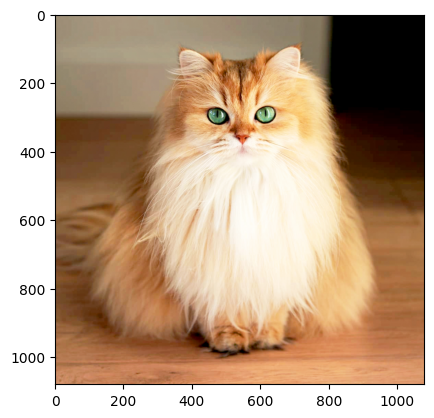

In [ ]:
image = cv2.imread('/content/cat.jpg')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()


### Các phương pháp thường sử dụng

Các phương pháp hay được sử dụng nhất trong các bài toán xử lý ảnh có thể tham khảo tại: https://imgaug.readthedocs.io/en/latest/source/augmenters.html

1. CropAndPad: Cắt hoặc thêm các pixel vào ảnh.

In [ ]:
import imgaug.augmenters as iaa


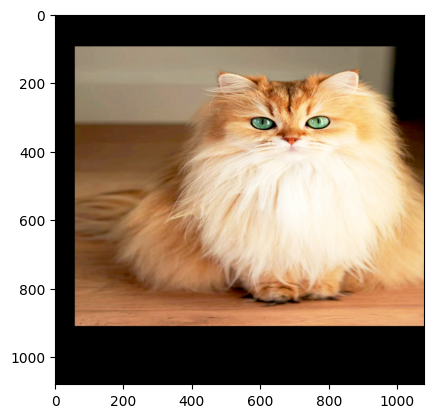

In [ ]:
# Sử dụng hàm CropAndPad với tham số percent=(-0.25, 0.25)

crop_and_pad = iaa.CropAndPad(percent=(-0.25, 0.25)) #-0.25 là cắt bớt 0.25, + là thêm

plt.imshow(cv2.cvtColor(crop_and_pad.augment_image(image), cv2.COLOR_BGR2RGB))
plt.show()

2. Flip: Flip left-right hoặc Flip up-down một số ảnh trong tập ảnh truyền vào

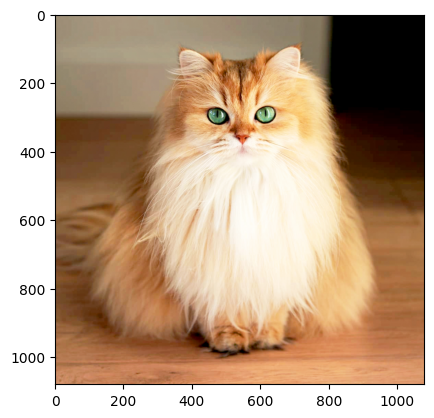

In [ ]:
# Flip left-right sử dụng hàm Fliplr với tham số 1.0
import imgaug.augmenters as iaa
flip_lr = iaa.Fliplr(0.5) #Flipr(thamso) thì sẽ là lật 100% ảnh theo chiều ngang

plt.imshow(cv2.cvtColor(flip_lr.augment_image(image), cv2.COLOR_BGR2RGB))
plt.show()

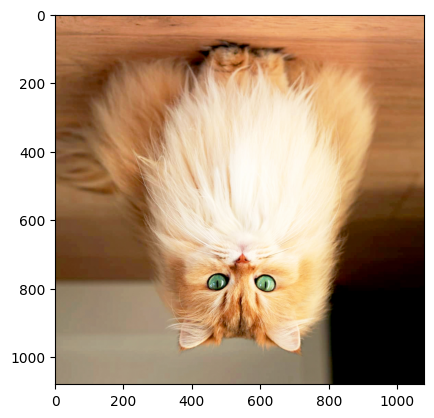

In [ ]:
# Flip up-down sử dụng hàm Flipud với tham số 1.0

flip_ud = iaa.Flipud(1.0) # Lật 100% ảnh theo chiều dọc

plt.imshow(cv2.cvtColor(flip_ud.augment_image(image), cv2.COLOR_BGR2RGB))
plt.show()

- Affine: Các phép biến đổi affine như scale, rotate, translate:

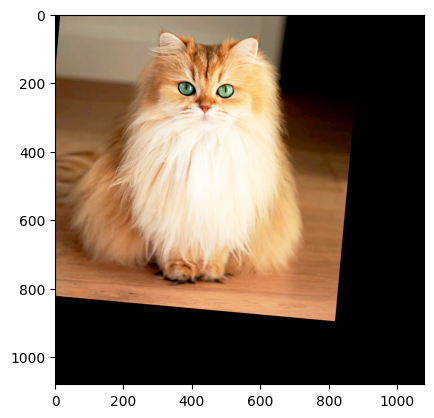

In [ ]:
# Biến đổi affine dùng hàm Affine với các tham số scale=(0.5, 1.5), rotate=(-15,15), translate_percent=(-0.2, 0.2)

affine = iaa.Affine(scale=(0.5, 1.5), rotate=(-15,15), translate_percent=(-0.2, 0.2))
# scale: giảm 50%, tăng 150% (thay đổi tỷ lệ ảnh)
# rotate: xoay ảnh theo đơn vị góc: độ
# translate_percent: dịch chuyển ảnh từ -20%-> 20%

plt.imshow(cv2.cvtColor(affine.augment_image(image), cv2.COLOR_BGR2RGB))
plt.show()

- Blur: Sử dụng các bộ lọc Gaussian hoặc Mean:

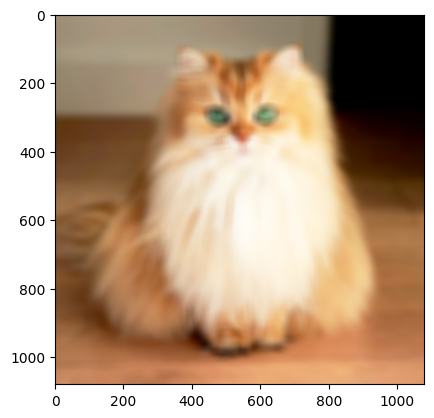

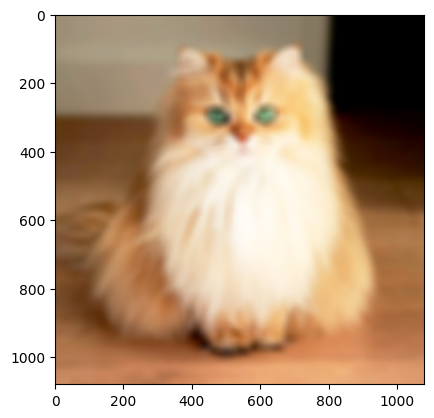

In [ ]:
# Sử dụng hàm AverageBlur để thực hiện Mean filter với tham số k = (11,31), GaussianBlur để thực hiện Gausian Blur với Sigma = (5,15)

'''
Hàm AverageBlur thực hiện lọc trung bình (mean filter).
Bộ lọc này làm mờ bằng cách thay bằng trung bình của các pixel xung quanh mỗi pixel.
tham số k chính là kích thước Kernel (ma trận nhân vào), k càng lớn thì càng mờ
'''

avg_blur = iaa.AverageBlur(k=(11,31))
plt.imshow(cv2.cvtColor(avg_blur.augment_image(image), cv2.COLOR_BGR2RGB))
plt.show()

'''
Hàm GaussianBlue thực hiện lọc theo pp gauss.
Kernel ở đây sẽ có kích thước cố định từ trước
Kernel Gaussian di chuyển qua toàn bộ ảnh, và giá trị của mỗi pixel trong ảnh được tính toán dựa trên toạ độ pixel tính từ pixel trung tâm theo phân phối Gaussian.
Tham số sigma: chính là mean, độ lệch chuẩn của phân phối gauss (độ lệch chuẩn càng lớn thì độ mờ của ảnh càng cao)

'''


gauss_blur = iaa.GaussianBlur(sigma=(5,15))
plt.imshow(cv2.cvtColor(gauss_blur.augment_image(image), cv2.COLOR_BGR2RGB))
plt.show()

- Dropout: Biến đổi ngẫu nhiên một phần ảnh thành các pixel đen

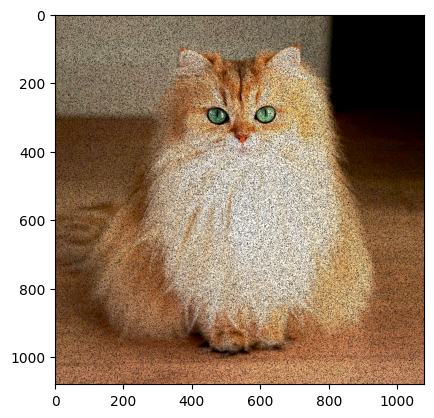

In [ ]:
# Dropout với tham số p = (0, 0.2)

# Tức là bỏ qua p phần nơron (%)
dropout = iaa.Dropout(p=(0, 0.2))

plt.imshow(cv2.cvtColor(dropout.augment_image(image), cv2.COLOR_BGR2RGB))
plt.show()

### Kết hợp nhiều augmenter

Trong thực tế, có nhiều chiến lược trong việc thực hiện các augmenter khác nhau, thư viện imgaug cũng hỗ trợ một số hàm để thực hiện công việc này:

- Sequential: Áp dụng các augmenter lần lượt theo thứ tự truyền vào:

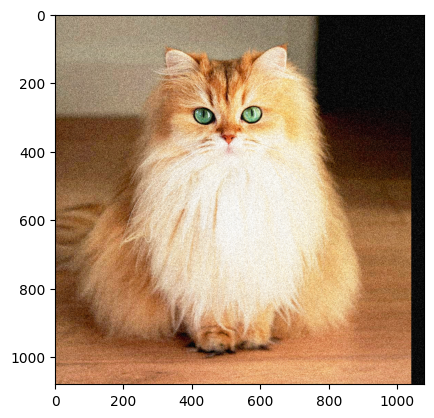

In [ ]:
aug = iaa.Sequential([
    iaa.Affine(translate_px={"x":(-40, 40)}),
    iaa.AdditiveGaussianNoise(scale=0.1*255)
])

#translate: x = (-40,40): di chuyển ảnh theo chiều ngang (x-axis) trong khoảng từ -40 đến 40 pixel.
#AdditiveGaussianNoise: Đây là phép biến đổi thêm nhiễu Gaussian vào ảnh.
plt.imshow(cv2.cvtColor(aug.augment_image(image), cv2.COLOR_BGR2RGB))
plt.show()

- SomeOf: Áp dụng ngẫu nhiên một vài augmenter trong list các augmenter:

In [ ]:
!pip3 install mxnet-mkl==1.6.0 numpy==1.23.1

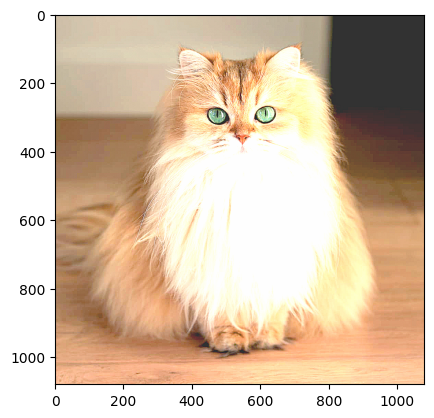

In [ ]:
aug = iaa.SomeOf(2, [
    iaa.Affine(rotate=45),
    iaa.AdditiveGaussianNoise(scale=0.2*255),
    iaa.Add(50, per_channel=True),
    iaa.Sharpen(alpha=0.5)
])
'''
iaa.Add(50): Phép biến đổi này thêm giá trị số nguyên 50 vào tất cả các pixel trong ảnh.
per_channel=True: Tham số này cho biết rằng giá trị được thêm vào sẽ được áp dụng riêng biệt cho mỗi kênh màu trong ảnh
'''

'''
iaa.Sharpen(alpha=0.5)
Phép biến đổi này làm tăng độ sắc nét của ảnh bằng cách áp dụng một bộ lọc làm sắc nét (sharpening filter).
alpha càng cao càng nét
'''

plt.imshow(cv2.cvtColor(aug.augment_image(image), cv2.COLOR_BGR2RGB))
plt.show()

- Sometimes: Áp dụng augmenter với xác suất p:

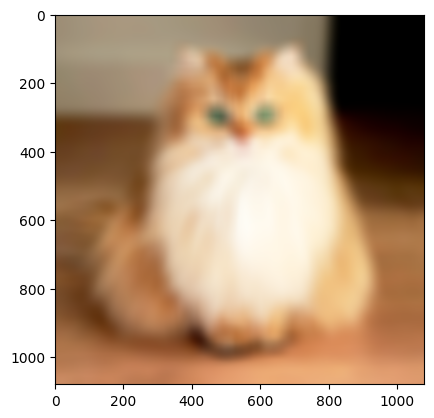

In [ ]:
aug = iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=20.0))

plt.imshow(cv2.cvtColor(aug.augment_image(image), cv2.COLOR_BGR2RGB))
plt.show()

### Kết hợp cùng thư viện Keras

Bây giờ chúng ta sẽ sử dụng các augmenter đã viết để thực hiện augment image trong quá trình huấn luyện mạng với thư viện Keras.

- Bước 1: Khởi tạo Augmenter:

In [ ]:
 # Sử dụng hàm Dropout với tham số p=(0, 0.002)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

dropout = iaa.Dropout(p=(0, 0.002))

- Bước 2: Xây dựng generator:

In [ ]:
class Generator(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

In [ ]:
training_data = Generator(x_train, y_train)
train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)

In [ ]:
test_data = Generator(x_test, y_test)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

Quan sát thử kết quả của generator bên trên:

torch.Size([32, 28, 28])


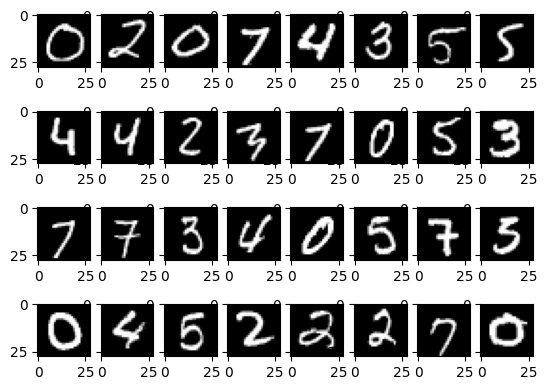

In [ ]:
for (batch_idx, target_tuple) in enumerate(train_dataloader):
    print(target_tuple[0].shape)
    for i in range(32):
        plt.subplot(4, 8, i + 1), plt.imshow(target_tuple[0][i], cmap='gray')
    plt.show()
    break

- Bước 3: Train model với fit_generator:

In [ ]:
use_cuda = torch.cuda.is_available()  #GPU cuda
best_loss = float('inf')

model = SimpleModel(dropout_rate = 0.5)

optimizer = torch.optim.Adadelta(model.parameters())

if use_cuda:
    model = torch.nn.parallel.DataParallel(model.cuda())   # , device_ids=[0, 1, 2, 3]
    torch.backends.cudnn.benchmark = True



In [ ]:
def train(epoch):
    print('\n ############################# Train phase, Epoch: {} #############################'.format(epoch))
    model.train()
    train_loss = 0

    print('\nLearning rate at this epoch is: ', optimizer.param_groups[0]['lr'], '\n')

    for (batch_idx, target_tuple) in enumerate(train_dataloader):
        if use_cuda:
            target_tuple = [target_tensor.cuda(non_blocking=True) for target_tensor in target_tuple]

        images, labels = target_tuple
        # Convert label to long type pytorch
        labels = torch.tensor(labels,dtype=torch.long)

        optimizer.zero_grad()  # zero the gradient buff
        output_tuple = model(images)

        loss = F.nll_loss(output_tuple, labels).cuda()

        loss.backward()  # retain_graph=True
        optimizer.step()

        train_loss += loss.item()  # loss
        print('########################### Epoch:', epoch, ', --  batch:',  batch_idx, '/', len(train_dataloader), ',   ',
              'Train loss: %.3f, accumulated average loss: %.3f ##############################' % (loss.item(), train_loss / (batch_idx + 1)))

    global best_loss
    train_loss /= len(train_dataloader)
    if train_loss < best_loss:
      noti = 'best_'
      best_loss = train_loss
    else:
      noti = ''
    print('saving...')
    state = {
      'weights': model.module.state_dict(),
      'optimizer_weight': optimizer.state_dict(),
      'train_loss': train_loss,
      'epoch': epoch,
    }
    os.makedirs('checkpoints', exist_ok=True)
    torch.save(state, 'checkpoints/model_' + noti + str(epoch) + '_epoch.pth')



In [ ]:
def test(epoch):
    print('\n ############################# Test phase, Epoch: {} #############################'.format(epoch))
    model.eval()
    with torch.no_grad():
        test_loss = 0

        for (batch_idx, target_tuple) in enumerate(test_dataloader):
            if use_cuda:
                target_tuple = [target_tensor.cuda(non_blocking=True) for target_tensor in target_tuple]

            images, labels = target_tuple
            # Convert label to long type pytorch
            labels = torch.tensor(labels,dtype=torch.long)
            output_tuple = model(images)

            loss = F.nll_loss(output_tuple, labels).cuda()

            test_loss += loss.item()  # loss
            print('########################### Epoch:', epoch, ', --  batch:',  batch_idx, '/', len(test_dataloader), ',   ',
                  'Test loss: %.3f, accumulated average loss: %.3f ##############################' % (loss.item(), test_loss / (batch_idx + 1)))



In [ ]:
no_epoch = 5
for epoch in range(no_epoch):
    train(epoch)
    test(epoch)

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
########################### Epoch: 2 , --  batch: 1583 / 1875 ,    Train loss: 0.379, accumulated average loss: 0.205 ##############################
########################### Epoch: 2 , --  batch: 1584 / 1875 ,    Train loss: 0.628, accumulated average loss: 0.205 ##############################
########################### Epoch: 2 , --  batch: 1585 / 1875 ,    Train loss: 0.245, accumulated average loss: 0.205 ##############################
########################### Epoch: 2 , --  batch: 1586 / 1875 ,    Train loss: 0.152, accumulated average loss: 0.205 ##############################
########################### Epoch: 2 , --  batch: 1587 / 1875 ,    Train loss: 0.056, accumulated average loss: 0.205 ##############################
########################### Epoch: 2 , --  batch: 1588 / 1875 ,    Train loss: 0.172, accumulated average loss: 0.205 ##############################
########################### Epoch: 2 , --  batch: